In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
r_data, rho_data = np.load("/home/connor/Documents/thindisk/data/exported_data_rho.npy")
r_data, tgas_data = np.load("/home/connor/Documents/thindisk/data/exported_data_tgas.npy")

## Density
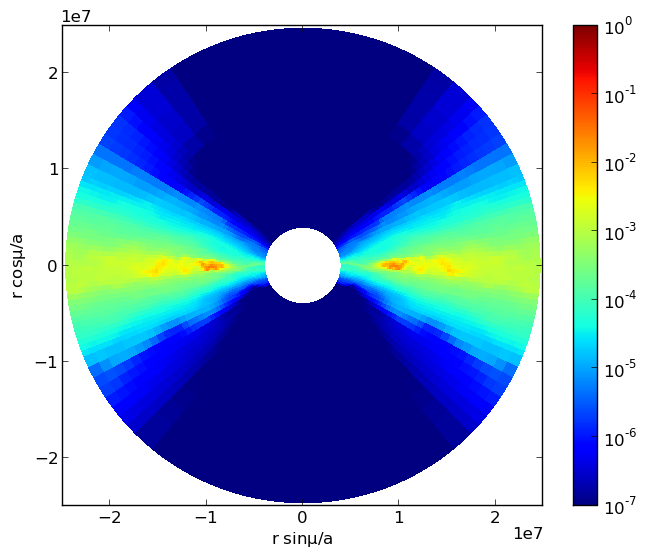

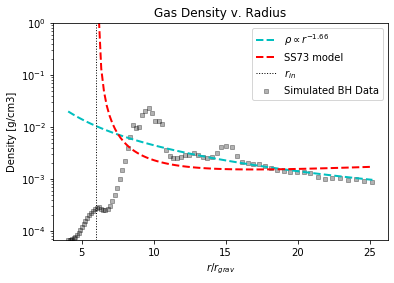

In [6]:
# Values for mass of the black hole and accretion rate
M = 6.62*u.solMass
Mdot = 0.000000009*u.solMass/u.yr

def num_dens(R, M, Mdot, alpha):
    m = (M / c.M_sun).decompose()
    mdot = (Mdot / (3e-8 * u.solMass / u.yr) * c.M_sun / M).decompose()
    r = (c.M_sun * R / M / (9*u.km)).decompose()
    return 4.3e17 * alpha**(-1) * mdot**(-2) * m**(-1) * r**(3/2) * (1 - r**(-1/2))**(-2) * 1/u.cm**3

def r_grav(M):
    return (c.G*M/c.c.cgs**2).to(u.cm)

plt.scatter(r_data/r_grav(M), rho_data, label='Simulated BH Data', c='k', marker='s', s=10, alpha=0.3) # plot the data

z = np.polyfit(np.log10(r_data[42:]), np.log10(rho_data)[42:], 1)
m = z[0]
b = z[1]
log_fit = 10**(b) * r_data**(m)
plt.plot(r_data/r_grav(M), log_fit, 'c--', label=r'$\rho \propto r^{{{:.2f}}}$'.format(m),lw=2)

r_model = np.linspace(M/u.solMass * 9.1e5, r_data[-1], 100)*u.cm # Create model r points
rho_model = num_dens(r_model, M, Mdot, 1.)* c.m_p.cgs # Calculate density at each r point using the model function
plt.plot(r_model/r_grav(M), rho_model, 'r--', label='SS73 model', lw=2) # plot the model

# Add a vertical line where r_in is located
plt.axvline(6, c='k', ls=':', lw=1, label='$r_{in}$')

plt.legend()
plt.title("Gas Density v. Radius")
plt.yscale('log')
plt.ylabel('Density [g/cm3]')
plt.xlabel(r'$r/r_{grav}$')
plt.ylim((min(rho_data), 1))
plt.show()

## Temperature
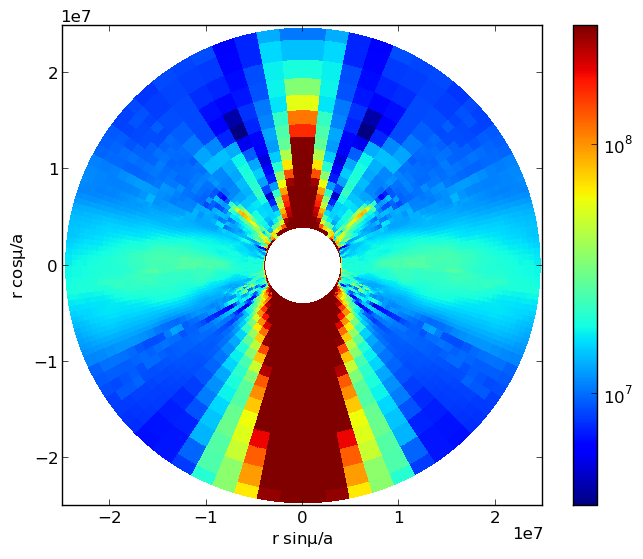

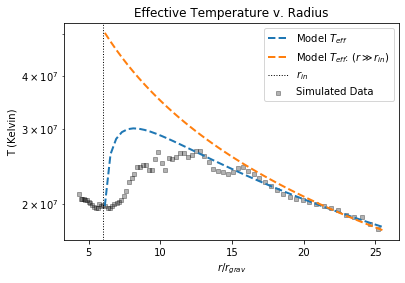

In [5]:
def F(r, M, Mdot, r_in):
    flux = 3. * c.G * M * Mdot / (8. * np.pi * r**3) * (1. - np.sqrt(r_in / r))    # Calculate the flux
    return flux.to(u.Unit("erg/(cm2 s)"))

def Teff(r, M, Mdot, r_in):
    '''
    A simple calculation of the effective temperature that uses the equation T_eff = (F/sigma)**(1/4). 
    Here, we plug in our flux equation for F. This includes information about r_in, the interior radius of the
    accretion disk.
    '''
    return ((F(r, M, Mdot, r_in)/c.sigma_sb)**(1/4)).decompose()

def Teff_approx(r, M, Mdot): 
    '''
    A calculation of the effective temperature that uses the equation T_eff = (F/sigma)**(1/4), where we have 
    plugged in F = 3 * G * M * Mdot / (8 * pi * r**3) for the flux, approximating out the dependence on r_in.
    This calculation should be correct when r (?????) r_in.
    '''
    numerator = 3 * c.G * M * Mdot
    denominator = 8 * np.pi * c.sigma_sb * (c.G * M / c.c**2)**3
    first_term = (numerator / denominator)**(1/4)
    second_term =(r/r_grav(M))**(-3/4)
    return (first_term * second_term).decompose() 

# This is the mass of the black hole used in the simulation
mass = 6.62*u.solMass

# Add the data line to the plot, with markers for individual data points
plt.scatter(r_data[3:]/r_grav(mass), tgas_data[3:], label='Simulated Data', marker='s', c='k', s=10, alpha=0.3)
# The [2:] in the line above grabs only the data from index 2 onwards -- ignoring the first two data points

accr_rate_approx = 0.000012*u.solMass/u.yr # These aren't right! Change the values to make the fits better.
accr_rate = 0.000025*u.solMass/u.yr # If we increase the accretion rate, what do we expect to happen to the temperature?

r_model = np.linspace(0.6e7, 2.5e7)*u.cm

tgas_approx = Teff_approx(r_model, mass, accr_rate_approx)
tgas = Teff(r_model, mass, accr_rate, 6*r_grav(mass)) # Remember that r_in should be about 3 graviational radii

# Plot the model lines
plt.plot(r_model/r_grav(mass), tgas, '--', label='Model $T_{eff}$', lw=2)
plt.plot(r_model/r_grav(mass), tgas_approx, '--', label='Model $T_{eff}$: $(r \gg r_{in})$', lw=2)

# Add a vertical line where r_in is located
plt.axvline(6, c='k', ls=':', lw=1, label='$r_{in}$')

# Format and label the plot
#plt.ylim([1.7e7, 6e7])
plt.title("Effective Temperature v. Radius")
plt.yscale('log')
plt.xlabel('$r/r_{grav}$')
plt.ylabel('T (Kelvin)')
plt.legend()
plt.show()